# Capstone Project: Modeling and Interpretation

### Imports

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, roc_auc_score
from imblearn.over_sampling import SMOTE

### Dataset

After the final dataset is read in, a target column was created and unnecessary columns for modeling were dropped to only keep the distance matrix as features. The decision to use an interpretable classification model was made based on the following simplified logic: by understanding what kind of venues are considered an important feature or have a degree of dependency with coffee shops, we can suggest clients to open their businesses near those venues. The best model will then be used to determine the categories of venues that should be looked at and potentially, together with the engineered features that were dropped, we can narrow down the location(s) even more.

In [2]:
capstone_df = pd.read_csv("../data/final_df_min.csv")

In [3]:
capstone_df["target"] = capstone_df["categories"].map(lambda x: 1 if x == "Coffee Shop" else 0)

In [4]:
capstone_df.drop(columns = ["area","categories","name","user_rate_as_pct_pop","freq","venues_per_capita","cs_per_capita","rating","user_ratings_total","price_level","Coffee Shop"], inplace = True)

In [5]:
capstone_df.head()

,ATM,Acai House,Accessories Store,Acupuncturist,Afghan Restaurant,African Restaurant,Airport,Airport Lounge,Airport Service,Alternative Healer,...,Windmill,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit,target
0,19511.372574,13979.911196,11198.426865,62759.515967,0.000000,13365.306366,15743.376839,20565.965024,4889.294047,17828.958588,...,23410.654951,4898.605383,417.555842,6208.456140,8257.048208,12565.688209,2466.149939,8707.117751,8721.235556,0
1,14136.570906,18560.157257,16007.462666,57497.347395,5382.747523,16368.791699,10389.712669,20029.347618,0.000000,22301.288157,...,27228.777586,1858.348631,5071.378933,11196.764306,13515.535041,17800.759025,4819.403358,5803.332714,5830.343855,0
2,19382.759806,13993.863443,11400.194018,62593.193753,211.060273,13278.261825,15621.447513,20378.449515,4751.309024,17837.861334,...,23379.105276,5051.895002,467.336745,6249.937742,8433.407727,12742.219449,2556.344207,8710.481353,8726.492864,0
3,19382.759806,13993.863443,11400.194018,62593.193753,211.060273,13278.261825,15621.447513,20378.449515,4751.309024,17837.861334,...,23379.105276,5051.895002,467.336745,6249.937742,8433.407727,12742.219449,2556.344207,8710.481353,8726.492864,0
4,19432.761716,14100.866265,11207.098384,62707.548759,126.411934,13489.351380,15661.094996,20648.784776,4818.601367,17950.692116,...,23536.633209,4964.247571,296.311477,6324.153683,8301.361417,12609.252160,2341.560429,8584.193959,8598.049520,0


### Model

*Note: Hyperparameter tuning using GridSearchCV and RandomizedSearchCV were done on the SF-only dataset which can be found in the [Appendix](./6.02-appendix_model_hyperparameter_tuning_SF_only.ipynb), from which the best parameters are used within the modeling process for the whole dataset*

##### Setting up X and y

In [6]:
X = capstone_df.drop(columns="target")
y = capstone_df["target"]

##### Train/Test Split

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state = 42)

##### SMOTE

Due to the imbalanced nature of the data (due to the fact that only 5.6% of total venues collected are Coffee Shop), SMOTE is applied in order to balance out the classes of data for the model to train on.

In [8]:
smo = SMOTE()
X_train_smote, y_train_smote = smo.fit_resample(X_train, y_train)

#### Baseline Model

In [9]:
y.value_counts(normalize = True)

0    0.943746
1    0.056254
Name: target, dtype: float64

The baseline model's accuracy is 94.4%.

#### Logistic Regression

In [9]:
logreg = LogisticRegression(C = 1e-05,
                            class_weight = None,
                            max_iter = 500,
                            penalty = 'none',
                            solver = 'newton-cg')

In [10]:
logreg.fit(X_train_smote,y_train_smote)

/Users/akhairunnisa/miniforge3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/akhairunnisa/miniforge3/lib/python3.9/site-packages/sklearn/utils/optimize.py:202: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn("newton-cg failed to converge. Increase the "


LogisticRegression(C=1e-05, max_iter=500, penalty='none', solver='newton-cg')

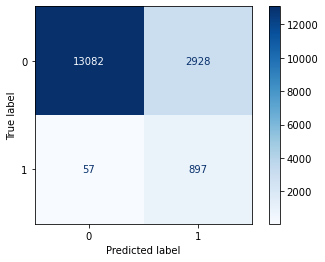

In [11]:
preds_logreg = logreg.predict(X_test)

tn, fp, fn, tp = confusion_matrix(y_test, preds_logreg).ravel()

plot_confusion_matrix(logreg, X_test, y_test, cmap='Blues', values_format='d');

In [12]:
logreg_train_score = logreg.score(X_train_smote,y_train_smote)
logreg_test_score = logreg.score(X_test,y_test)
logreg_test_sensitivity = tp / (tp + fn)
logreg_test_specificty = tn / (tn + fp)
logreg_roc_auc = roc_auc_score(y_test,logreg.predict_proba(X_test)[:,1])

In [13]:
print(f'Logistic Regression Train Accuracy: {logreg_train_score}')
print(f'Logistic Regression Test Accuracy: {logreg_test_score}')
print(f'Logistic Regression Test Sensitivity: {logreg_test_sensitivity}')
print(f'Logistic Regression Test Specificity: {logreg_test_specificty}')
print(f'Logistic Regression Test ROC-AUC Score: {logreg_roc_auc}')

Logistic Regression Train Accuracy: 0.8932036813392745
Logistic Regression Test Accuracy: 0.8240391417118604
Logistic Regression Test Sensitivity: 0.940251572327044
Logistic Regression Test Specificity: 0.8171143035602748
Logistic Regression Test ROC-AUC Score: 0.9247977875463056


Overall performance of the Logistic Regression Model is worse than the baseline model, with a slight overfit towards the training data by 7%. We can also observe that the model is more likely to predict True Positives (sensitivity of 94%) than True Negatives (specificity of 82%), with 57 False Negatives and 2,928 False Positives. Looking at the ROC-AUC score we know that the model is able to distinguish between classes by 92%.

#### Random Forest

In [15]:
rfc = RandomForestClassifier(n_estimators= 750,
                             min_samples_split= 2,
                             min_samples_leaf= 2,
                             max_features= 'auto',
                             max_depth= 10,
                             class_weight= 'balanced')

In [16]:
rfc.fit(X_train_smote,y_train_smote)

RandomForestClassifier(class_weight='balanced', max_depth=10,
                       min_samples_leaf=2, n_estimators=750)

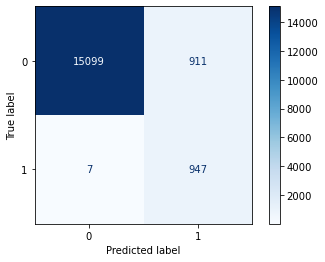

In [17]:
preds_rfc = rfc.predict(X_test)

tn, fp, fn, tp = confusion_matrix(y_test, preds_rfc).ravel()

plot_confusion_matrix(rfc, X_test, y_test, cmap='Blues', values_format='d');

In [18]:
rfc_train_score = rfc.score(X_train_smote,y_train_smote)
rfc_test_score = rfc.score(X_test,y_test)
rfc_test_sensitivity = tp / (tp + fn)
rfc_test_specificty = tn / (tn + fp)
rfc_roc_auc = roc_auc_score(y_test,rfc.predict_proba(X_test)[:,1])

In [19]:
print(f'Random Forest Train Accuracy: {rfc_train_score}')
print(f'Random Forest Test Accuracy: {rfc_test_score}')
print(f'Random Forest Test Sensitivity: {rfc_test_sensitivity}')
print(f'Random Forest Test Specificity: {rfc_test_specificty}')
print(f'Random Forest Test ROC-AUC Score: {rfc_roc_auc}')

Random Forest Train Accuracy: 0.9700162412026819
Random Forest Test Accuracy: 0.9458854043857581
Random Forest Test Sensitivity: 0.9926624737945493
Random Forest Test Specificity: 0.9430980637101811
Random Forest Test ROC-AUC Score: 0.9972657943083267


Overall performance of the Random Forest Model is good, slightly better when compared to the baseline model by ~0.2% and a slight overfit towards the training data by 2.4%. We can also observe that the model is more likely to predict True Positives (sensitivity of 99%) than True Negatives (specificity of 94%), with 7 False Negatives and 911 False Positives. Looking at the ROC-AUC score we know that the model is able to distinguish between classes almost perfectly, by 99.7%.

#### Extra Trees

In [21]:
et = ExtraTreesClassifier(n_estimators= 100,
                          min_samples_split= 4,
                          min_samples_leaf= 5,
                          max_features= 'auto',
                          max_depth = 10,
                          class_weight= 'balanced')

In [22]:
et.fit(X_train_smote,y_train_smote)

ExtraTreesClassifier(class_weight='balanced', max_depth=10, min_samples_leaf=5,
                     min_samples_split=4)

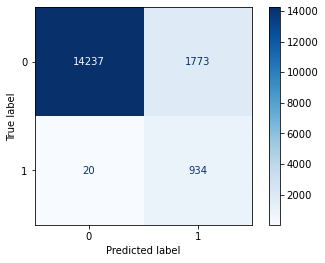

In [23]:
preds_et = et.predict(X_test)

tn, fp, fn, tp = confusion_matrix(y_test, preds_et).ravel()

plot_confusion_matrix(et, X_test, y_test, cmap='Blues', values_format='d');

In [24]:
et_train_score = et.score(X_train_smote,y_train_smote)
et_test_score = et.score(X_test,y_test)
et_test_sensitivity = tp / (tp + fn)
et_test_specificty = tn / (tn + fp)
et_roc_auc = roc_auc_score(y_test,et.predict_proba(X_test)[:,1])

In [25]:
print(f'Extra Trees Train Accuracy: {et_train_score}')
print(f'Extra Trees Test Accuracy: {et_test_score}')
print(f'Extra Trees Test Sensitivity: {et_test_sensitivity}')
print(f'Extra Trees Test Specificity: {et_test_specificty}')
print(f'Extra Trees Test ROC-AUC Score: {et_roc_auc}')

Extra Trees Train Accuracy: 0.9358680714612918
Extra Trees Test Accuracy: 0.8943055883046451
Extra Trees Test Sensitivity: 0.9790356394129979
Extra Trees Test Specificity: 0.8892567145534042
Extra Trees Test ROC-AUC Score: 0.9809013169180164


Overall performance of the Extra Trees Model is better than the Logistic Regression model, however is worse than the Baseline Model by 5%. It is also slighty overfit towards the training data by ~4%. We can also observe that the model is more likely to predict True Positives (sensitivity of 98%) than True Negatives (specificity of 89%), with 50 False Negatives and 200 False Positives. Looking at the ROC-AUC score we know that the model is able to distinguish between classes pretty well by 98%.

### Evaluation

In [27]:
metrics_summary_dic = {
    "Metrics":["Train Accuracy","Test Accuracy","Test Sensitivity","Test Specificity","Test ROC-AUC Score"],
    "Logistic Regression":[logreg_train_score,logreg_test_score,logreg_test_sensitivity,logreg_test_specificty,logreg_roc_auc],
    "Random Forest Classifier":[rfc_train_score,rfc_test_score,rfc_test_sensitivity,rfc_test_specificty,rfc_roc_auc],
    "Extra Trees Classifier":[et_train_score,et_test_score,et_test_sensitivity,et_test_specificty,et_roc_auc]
}

In [28]:
metrics_summary = pd.DataFrame(metrics_summary_dic)
metrics_summary.set_index("Metrics", inplace=True)

In [29]:
metrics_summary = round(metrics_summary[metrics_summary.columns],3)

In [30]:
metrics_summary

,Logistic Regression,Random Forest Classifier,Extra Trees Classifier
Metrics,,,
Train Accuracy,0.893,0.970,0.936
Test Accuracy,0.824,0.946,0.894
Test Sensitivity,0.940,0.993,0.979
Test Specificity,0.817,0.943,0.889
Test ROC-AUC Score,0.925,0.997,0.981


Looking at the metrics summary above, we can conclude that Random Forest Classifier is the best model to use because it is the most accurate, relatively balanced and is able to split the data almost perfectly at 99.7%. Below are the top 20 feature importance that would be used to determine the best location(s) to open a coffee shop.

In [20]:
pd.DataFrame(list(zip(X_train_smote.columns,rfc.feature_importances_)), columns = ["features","importance"]).sort_values("importance",ascending = False).head(20)

,features,importance
277,Park,0.032909
292,Pizza Place,0.017926
199,Ice Cream Shop,0.015630
238,Mexican Restaurant,0.014601
29,Bakery,0.012860
66,Café,0.010776
59,Burger Joint,0.009781
134,Farmers Market,0.009520
286,Pet Store,0.008387
48,Bookstore,0.008228
